# Plotting Fraunhofer Lines



## This is what I'm supposed to do: 

1. Deblaze and normalize the data by dividing out the echelle blaze function
2. Transform the wavelength solution of the data to constant RV space
3. Download a corresponding synthetic or empirical spectrum and transform its wavelength solution to constant RV space
4. Run a chi-squared test on the data and the empirical spectrum to determine doppler shift
5. Shift the data to be in the rest frame

### doing 0: reducing the spectra to be 1D:


In [2]:
#importing recommended libraries: 

from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

In [3]:
import seaborn as sns
sns.set_theme()

In [4]:
''' HDUL files are  logical header/data units (HDU) which i think just gives a 
table that has units that are assigned to each column? '''

' HDUL files are  logical header/data units (HDU) which i think just gives a \ntable that has units that are assigned to each column? '

## for importing data, im supposed to use NEID 

use the following link: 

<https://neid.ipac.caltech.edu/search.php>

if it doesnt do it automatically, the object is HD 10700 and the data level is 1 

>The wavelength range for NA I lines is 4700-6000 angstroms (470-600 nm)

In [45]:
#reading in data and assigning it to arrays 
#for windows, the path needs double backslashes when copying as a location

star = 'HD 10700' 
data_path = 'C:\\Users\\alica\workspace\\Fraunhofer Line Drafts\\neidL1_20220118T021017.fits' 
# APF_flux_path = '/datag/blpd0/datax/apf/rarj.224.fits'

file = fits.open(data_path)
# fl_file = fits.open(APF_flux_path)
wl_image = file['SCIWAVE'].data
fl_image = file['SCIFLUX'].data

#so far I am only working with one file

In [46]:
file.info() #this just reads the table values in a simplifed format

Filename: C:\Users\alica\workspace\Fraunhofer Line Drafts\neidL1_20220118T021017.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     745   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float64   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float64   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float64   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2451   (9216, 122)   float64   


### now im not entirely sure why this is important or what to do with this information but hopefully i get it down the road?

Below is the given graph for the wavelength vs pixel count off of the NEID archive for the fits file i am using

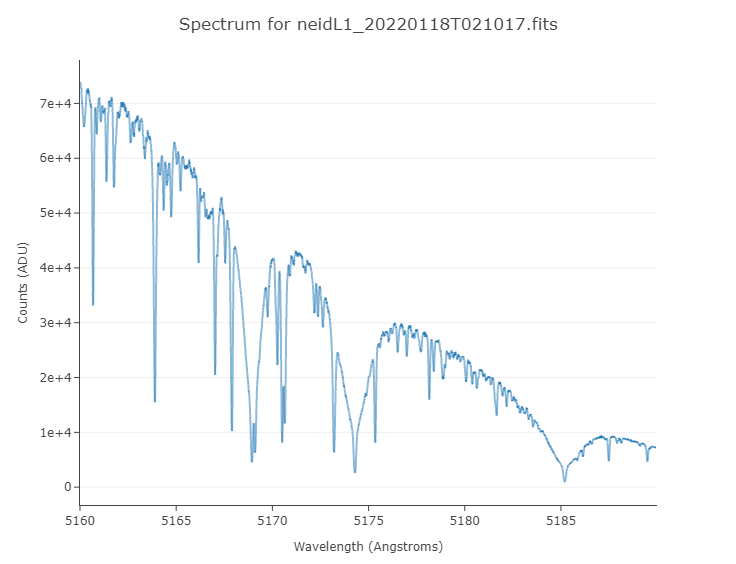

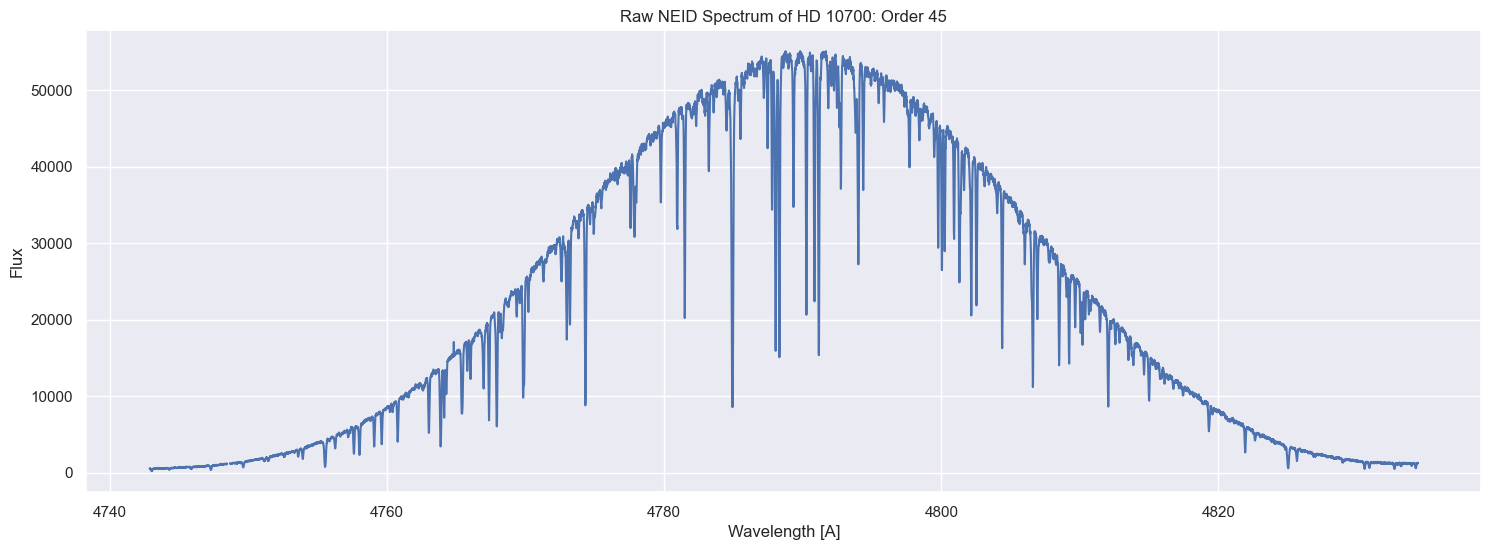

In [42]:
#next block (this plots the raw data hopefully)

plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams.update({'font.size': 20})

order = 45
wl = wl_image[order]
flux = fl_image[order] #reassigned below, so this will be fixed -- just making a note --
plt.plot(wl,flux)

plt.title('Raw NEID Spectrum of ' + star + ': Order ' + str(order)) #fix title 
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

#okay so far so good? Looks kinda too bellshaped but maybe thats okie?

In [53]:
#the wl_image array was empty:

fits.open(data_path).info()

Filename: C:\Users\alica\workspace\Fraunhofer Line Drafts\neidL1_20220118T021017.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     745   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float64   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float64   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float64   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2451   (9216, 122)   float64   


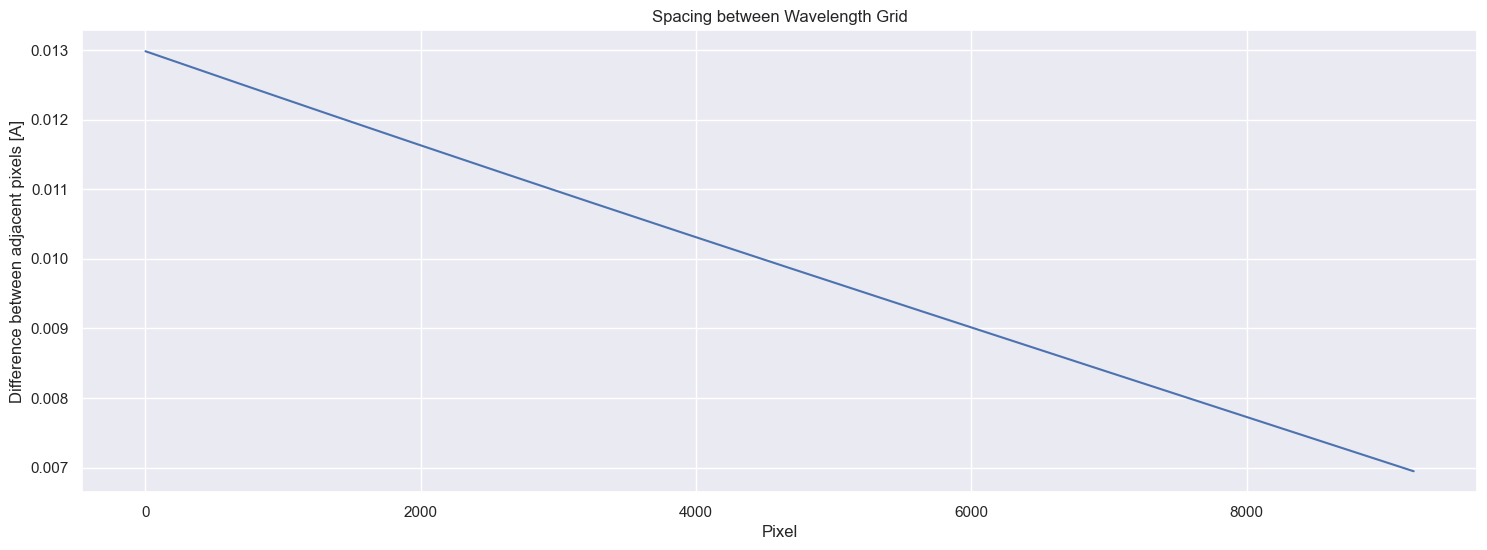

In [9]:
#okie time for the next chunk!
plt.plot(np.arange(len(wl) - 1), (wl[1:] - wl[:-1]))
plt.title('Spacing between Wavelength Grid')
plt.xlabel('Pixel')
plt.ylabel('Difference between adjacent pixels [A]')
plt.show()

# Spacing between pixels decreases at greater wavelengths.
#this isnt chunky like the same one, but hopefully thats okie?

# part 1: Dividing out the Echelle Blaze Function
## NOTE: I still need to fully understand what Im coding in this section 

Information for what the Echelle Blaze Function even is:

<https://en.wikipedia.org/wiki/Blazed_grating>

### Objective: 
>Divide the data into bins of 100 pixels. Find the flux value in the 95th percentile within each bin and plot these flux values onto the wavelength values. Divide the APF flux spectrum by the fit of the 95th percentile flux values.

From what i understand from that, is that for each 100 pixels, the "brightest" 5 will make it through and then those get plotted

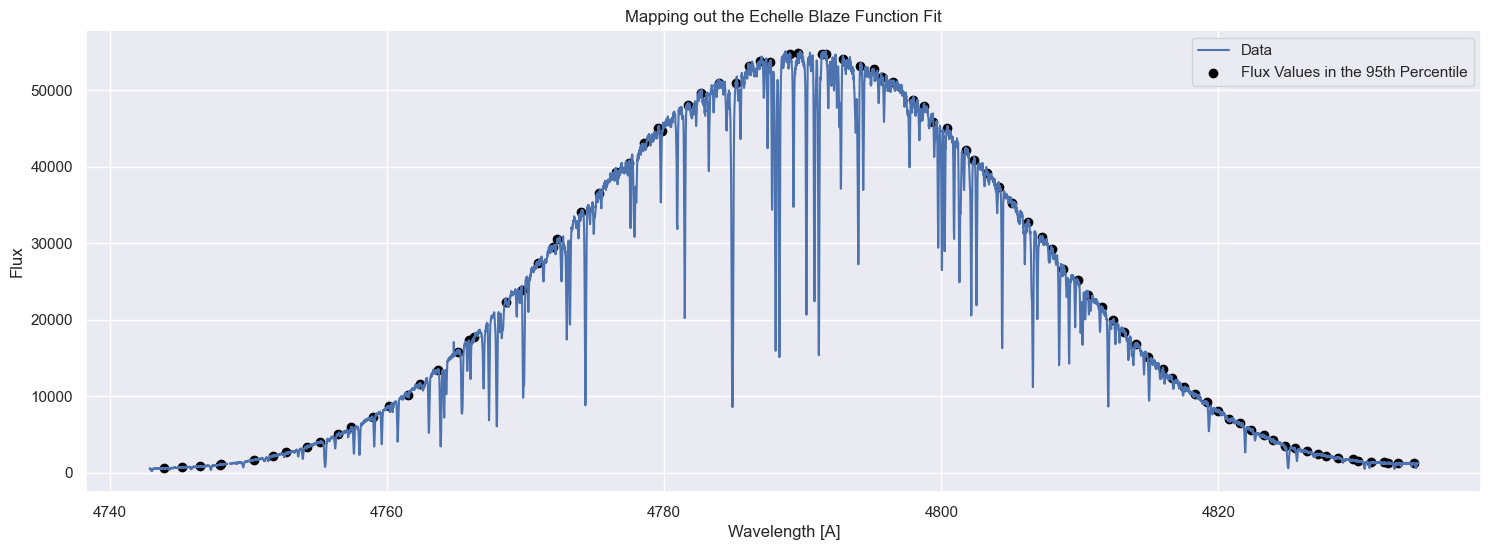

In [10]:
#given code: this feels like cheating lol i gotta go back and understand this fully 

bin = 100

# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wl) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wl[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wl, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

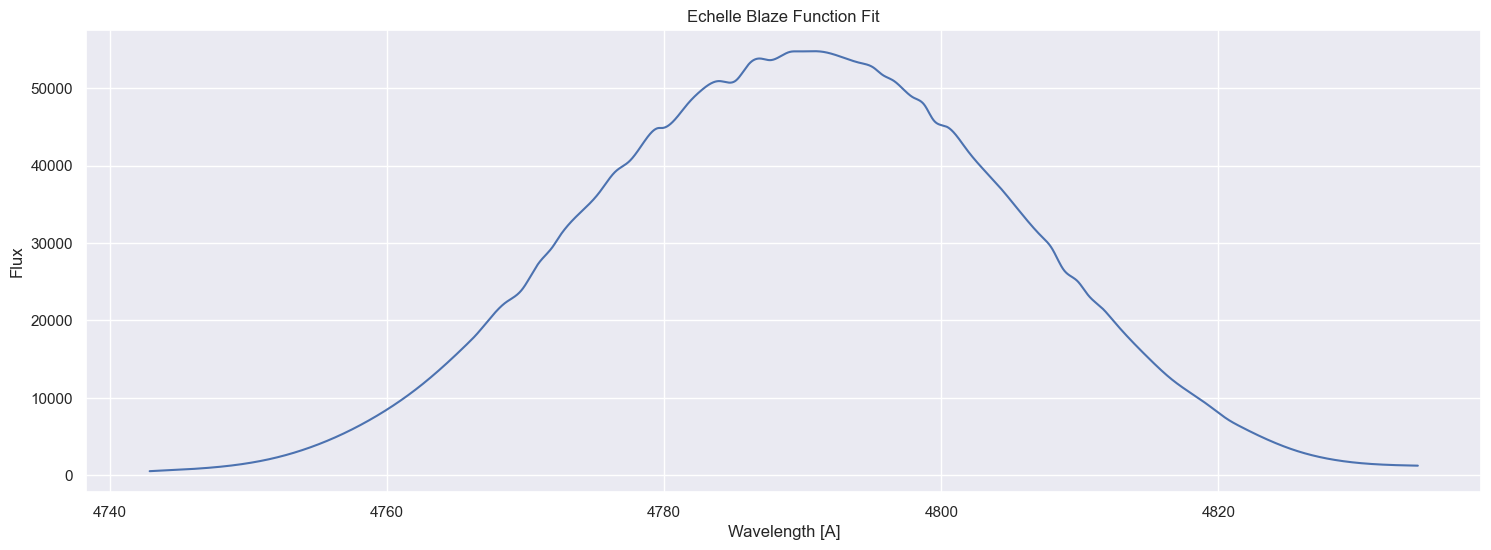

In [11]:
#Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. 
#Set s to 500000 to smooth the fit.

spl = splrep(wl_values, fl_values, s = 500000) #uses a B-Spline fitting method 
flux_fit = splev(wl, spl)
plt.plot(wl, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.show()

B-Spline fitting information: (scipy.interpolate.splrep)

<https://en.wikipedia.org/wiki/B-spline>

<https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html>

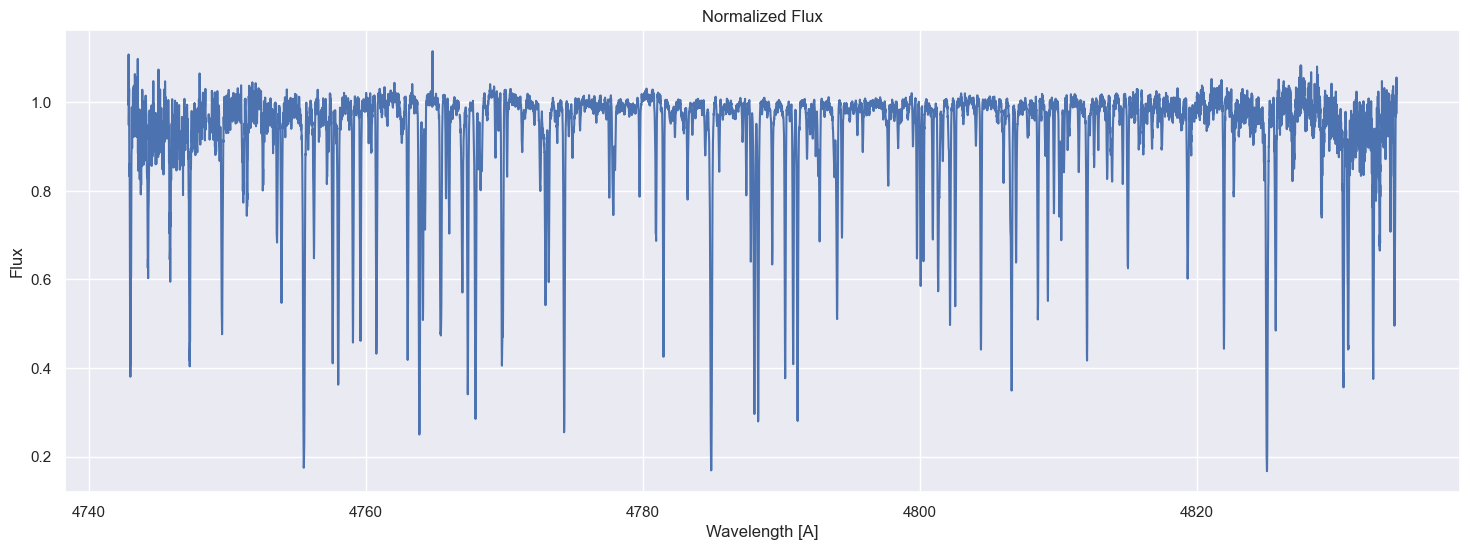

In [12]:
#this is supposed to divide the fit from the data and make it normalized

first_normalized_flux = flux / flux_fit
plt.plot(wl, first_normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Normalized Flux')
plt.show()

## Normalize again

95th percentile isnt thebest we can do, so normalizing again but in this time to the 98th percentile and then divide again. 

ensures its normalized to 1

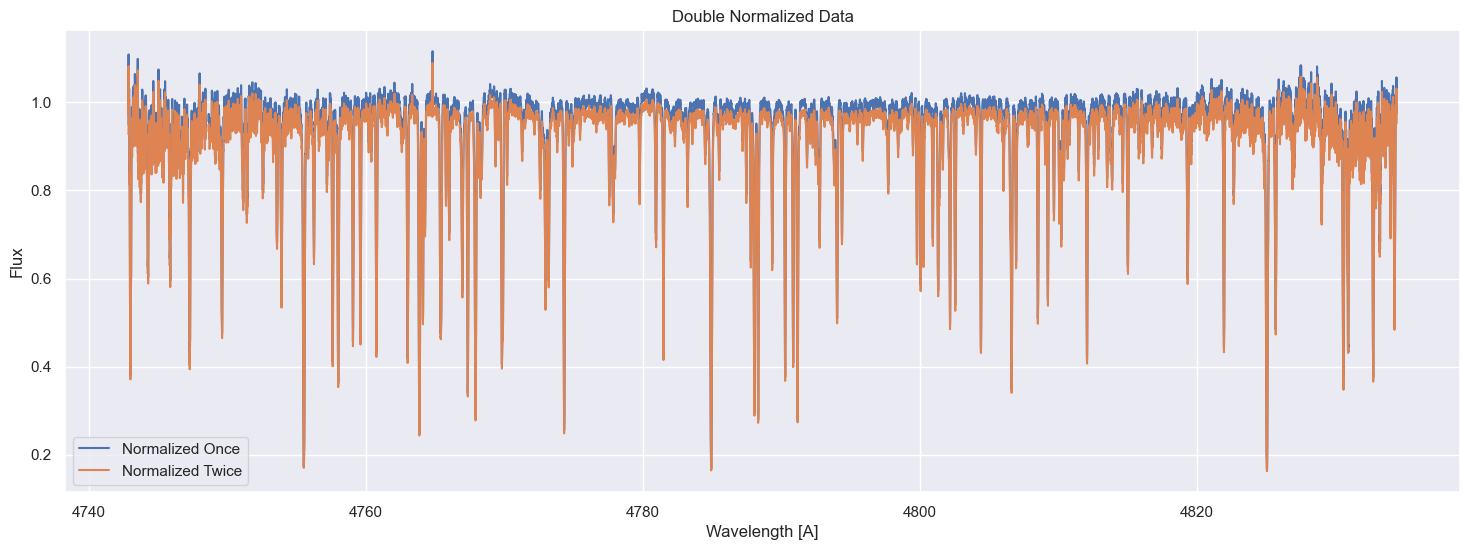

In [13]:
flux98 = np.nanpercentile(first_normalized_flux, 98) #fixed the bug mentioned below 
normalized_flux = first_normalized_flux / flux98

plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
plt.plot(wl, normalized_flux, label = 'Normalized Twice')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data')
plt.show()

### now this isnt printing the second normalization, so that means we need to do some debugging! 

flux98 isnt getting any values. now why is that?

even an array of zeros makes more sense than whats happening, so where is the error?

Found it lol: 

<https://stackoverflow.com/questions/30836032/why-does-np-percentile-return-nan-for-high-percentiles>

the percentile was so high that np.percentile considered them infinite and assigned them to be nan. using nanpercentile overrides that.

>this raises the question as to why Zoe's data didnt have that issue but mine did. . .

## Part 2: Regriding the Wavelength Grid to be in Constant RV Space

Plot the normalized flux values onto the original wavelength grid, create a new wavelength grid that is log lambda spaced, and then interpolate onto the new wavelength grid. This will create a spectrum that is in constant RV space, which will allow for a straightforward calculation of the Doppler shift.


In [14]:
f = scipy.interpolate.interp1d(wl, normalized_flux, kind='linear')

#note: breaks down if quadratic or cubic 

In [15]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 # km/s  (?) why did she choose 1? 
C = 299792.458 #km/s
wl_start = min(wl) + 0.2
wl_end = max(wl) - 0.2

CDELT1 = np.log10(dv/C +1) # wavelength grid step size

CRVAL1 = np.log10(wl_start)  # log of starting wavelength value
CRVALN = np.log10(wl_end)    # log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) / CDELT1  # total number of points

p = np.arange(NAXIS1) # array of total points
wl2 = 10 ** (CRVAL1 + CDELT1 * p)  # new array of wavelength values

# interpolate flux values onto log spaced wavelength grid
flux2 = f(wl2)

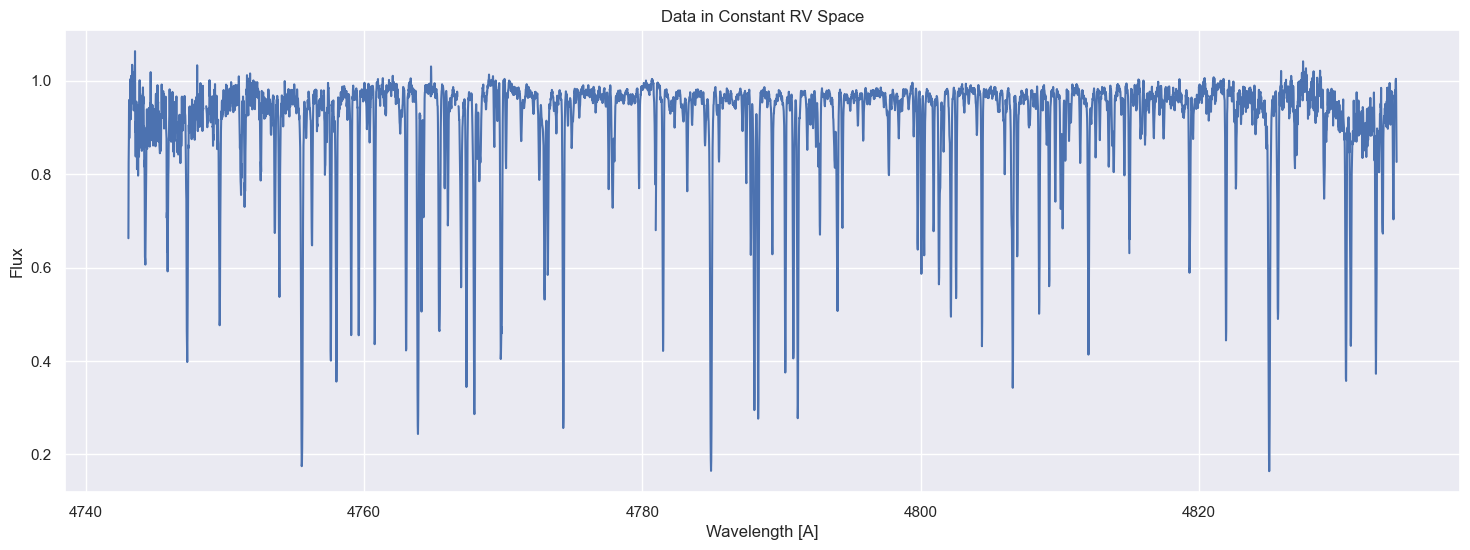

In [16]:
#Plot the new wavelength grid against flux values. 
#This should look the same as before; however, the wavelengths are now velocity spaced

plt.plot(wl2, flux2)
#plt.plot(wl,normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Data in Constant RV Space')
# plt.ylim(0.9,1)
# plt.xlim(4800,4810)
plt.show()

### Okie time for some more debugging since nothing is showing up again!

note: 

the f interpolation breaks down when the type is 'cubic' or 'quadratic'

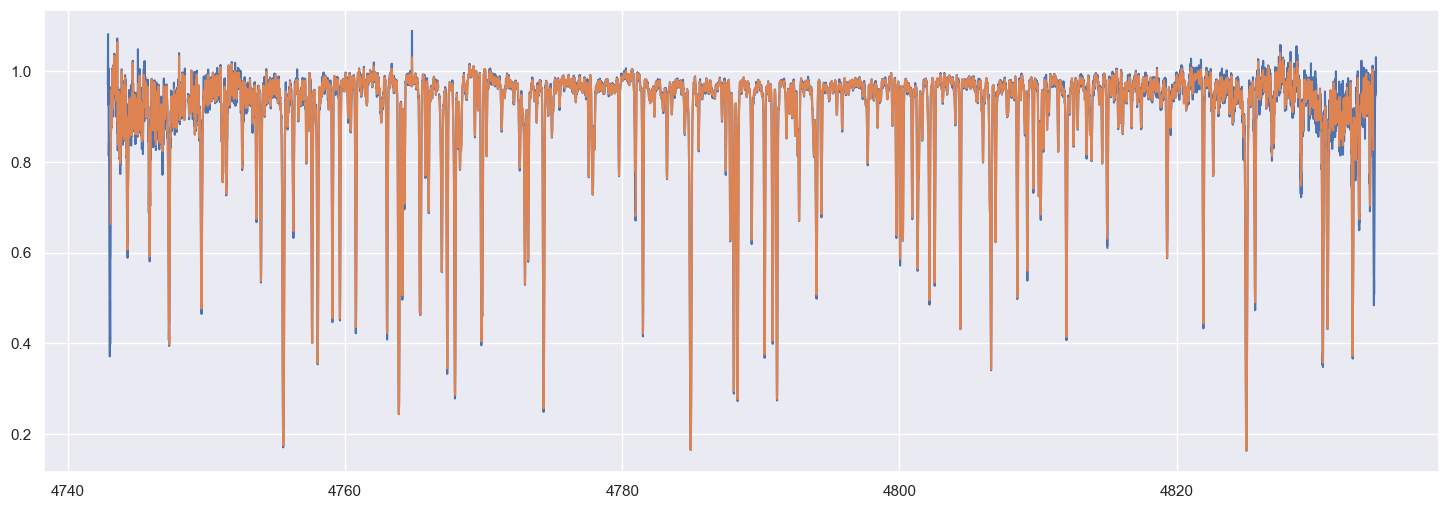

In [17]:
#comparing the shift to see if it makes sense (still unsure)
plt.plot(wl, normalized_flux, '-', wl2, flux2, '-')

In [18]:
len(wl2)

5705

## Part 3: Taking the Sun's spectrum and transforming it to RV Space

Read the empirical solar spectrum using astropy.io.fits. There are two arrays: one is the wavelength from around 3000 angstroms to 12,500 Angstroms, and the second is the corresponding flux array. Truncate it to match the wavelength range of the APF data.

In [19]:
solar_spectrum_path = "C:\\Users\\alica\\workspace\\Fraunhofer Line Drafts\\nso.fits"
solar_spectrum = fits.open(solar_spectrum_path)

In [20]:
solar_spectrum.info()

Filename: C:\Users\alica\workspace\Fraunhofer Line Drafts\nso.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1097840,)   float64   
  1                1 ImageHDU         6   (1097840,)   float64   


In [21]:
#still need to go over:

wl_temp = solar_spectrum[0].data
fl_temp = solar_spectrum[1].data

# wavelengths of APF data -- turning into my NEID data

#this is giving the starting point of our data set:
min_wl = min(wl2) - 8 #why 8 doe
absolute_difference_function = lambda list_value: abs(list_value-min_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
min_index = wl_temp.tolist().index(w)

#this gives the end point:
max_wl = max(wl2) + 8
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
max_index = wl_temp.tolist().index(w)

wl_syn_temp = wl_temp[min_index:max_index] #syn for synthetic?
fl_syn_temp = fl_temp[min_index:max_index]


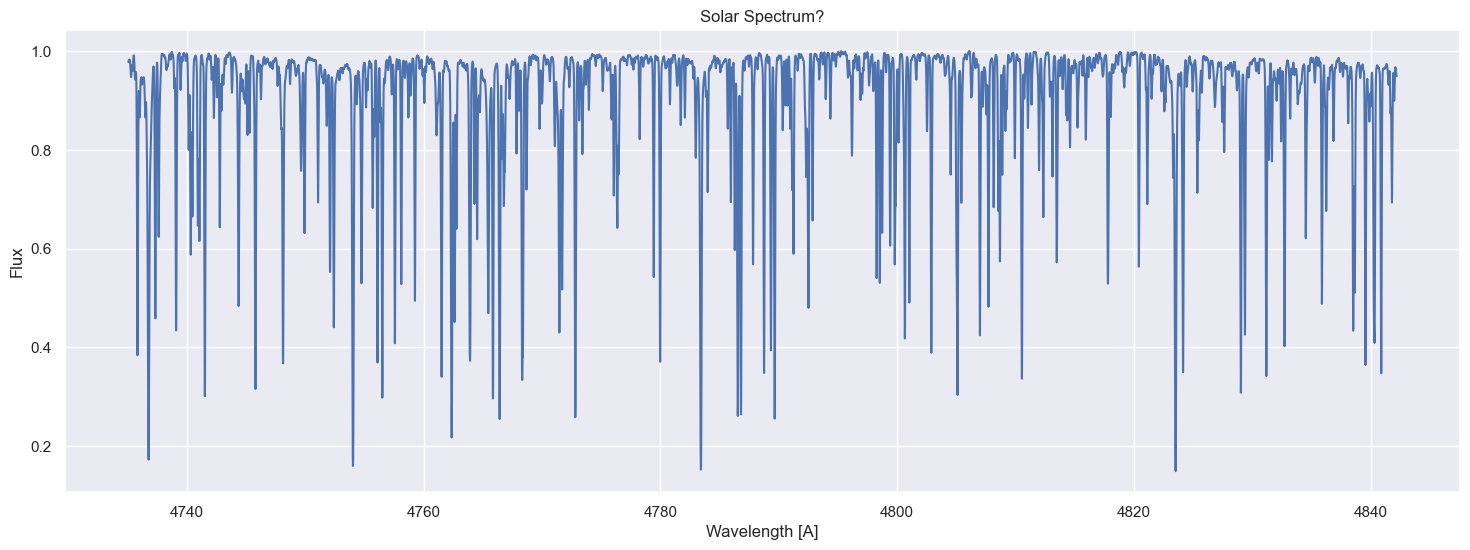

In [22]:
#plotting
plt.plot(wl_syn_temp, fl_syn_temp)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum?')
plt.show()

this doesn't seem right to me, but just because it looks not like the one in the guide.

I dont have intuition on what the sun's spectrum should really look like in this regard

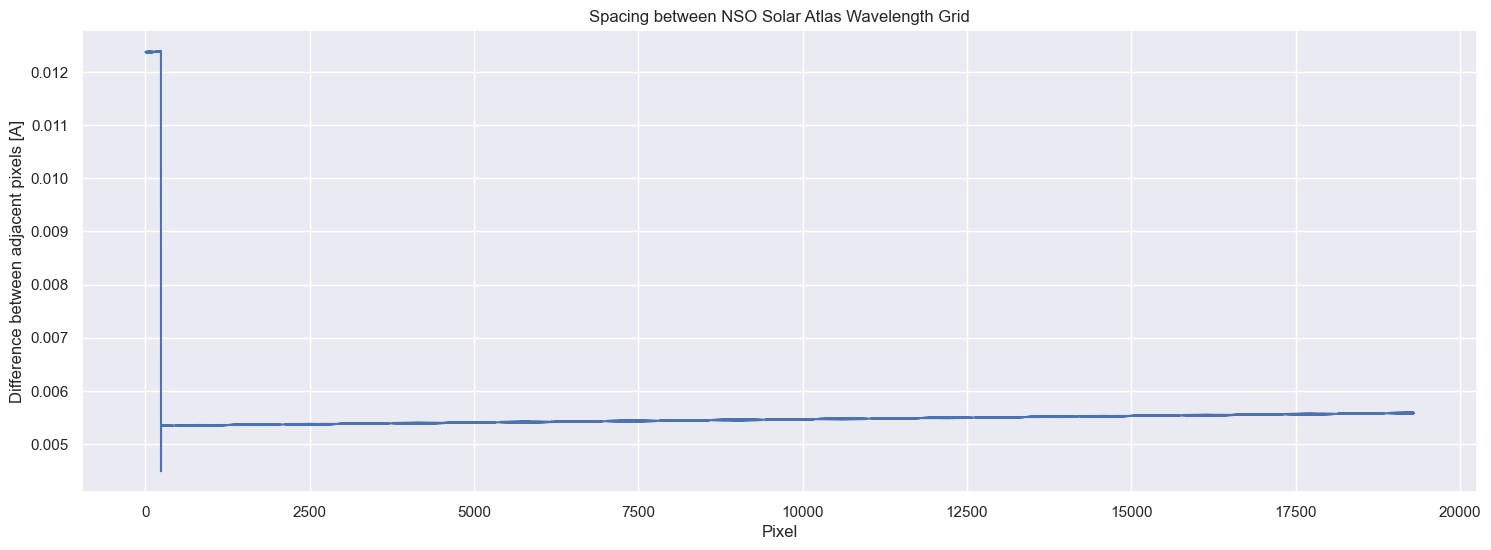

In [23]:
#spacing thing again:
plt.plot(np.arange(len(wl_syn_temp) - 1), (wl_syn_temp[1:] - wl_syn_temp[:-1]))
plt.title('Spacing between NSO Solar Atlas Wavelength Grid')
plt.xlabel('Pixel')
plt.ylabel('Difference between adjacent pixels [A]')
plt.show()

Well thats not right

In [24]:
#rinse and repeat:
f = scipy.interpolate.interp1d(wl_syn_temp, fl_syn_temp, kind='cubic')

In [25]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 #km/s
C = 299792.458 #km/s
wl_start = min(wl_syn_temp) + 0.2
wl_end = max(wl_syn_temp) - 0.2

CDELT1 = np.log10(dv/C +1) #wavelength grid step size

CRVAL1 = np.log10(wl_start)  #log of starting wavelength value
CRVALN = np.log10(wl_end)    #log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) /CDELT1  #total number of points

p = np.arange(NAXIS1) #array of total points
wl_syn = 10 ** (CRVAL1 + CDELT1 * p)  #array of wavelength values

# interpolate flux values onto log spaced wavelength grid
fl_syn = f(wl_syn)

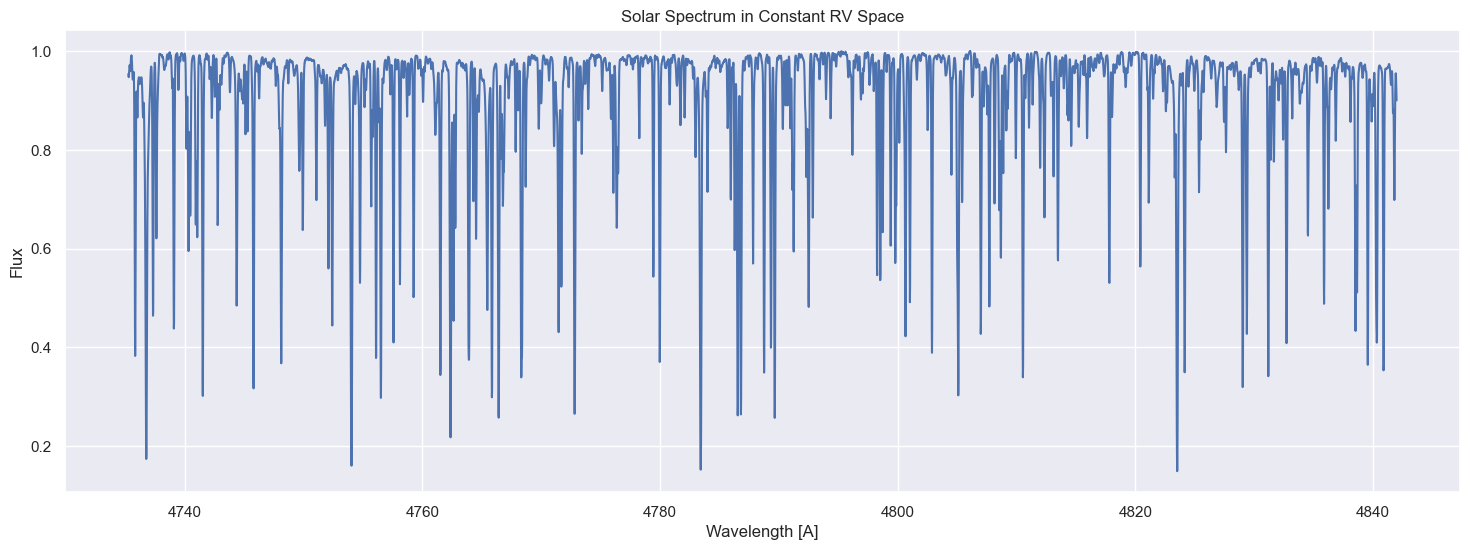

In [26]:
plt.plot(wl_syn, fl_syn)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum in Constant RV Space')
plt.show()

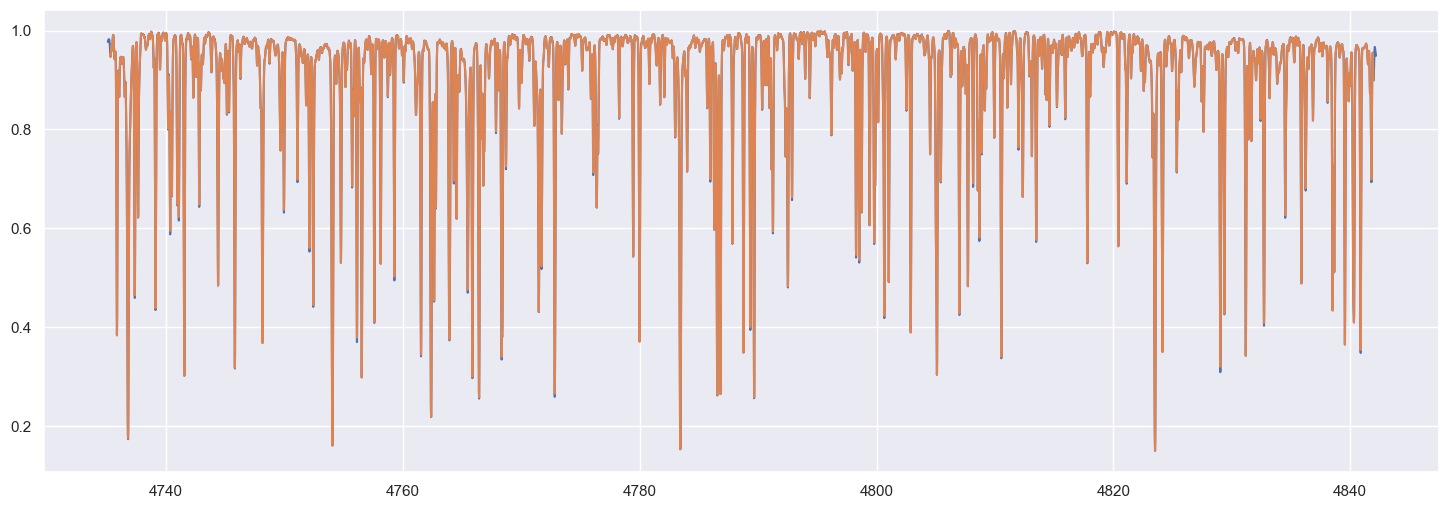

In [27]:
#comparing the shift to see if it makes sense (still unsure)
plt.plot(wl_syn_temp, fl_syn_temp, '-', wl_syn, fl_syn, '-')

## Part 4: Chi Squared test to find doppler shift

## I spoke with the other research UGs and they both seemed to skip parts 3 and 4 and just went straight to "zooming in to find the Na D lines, so I'm going to try that below:

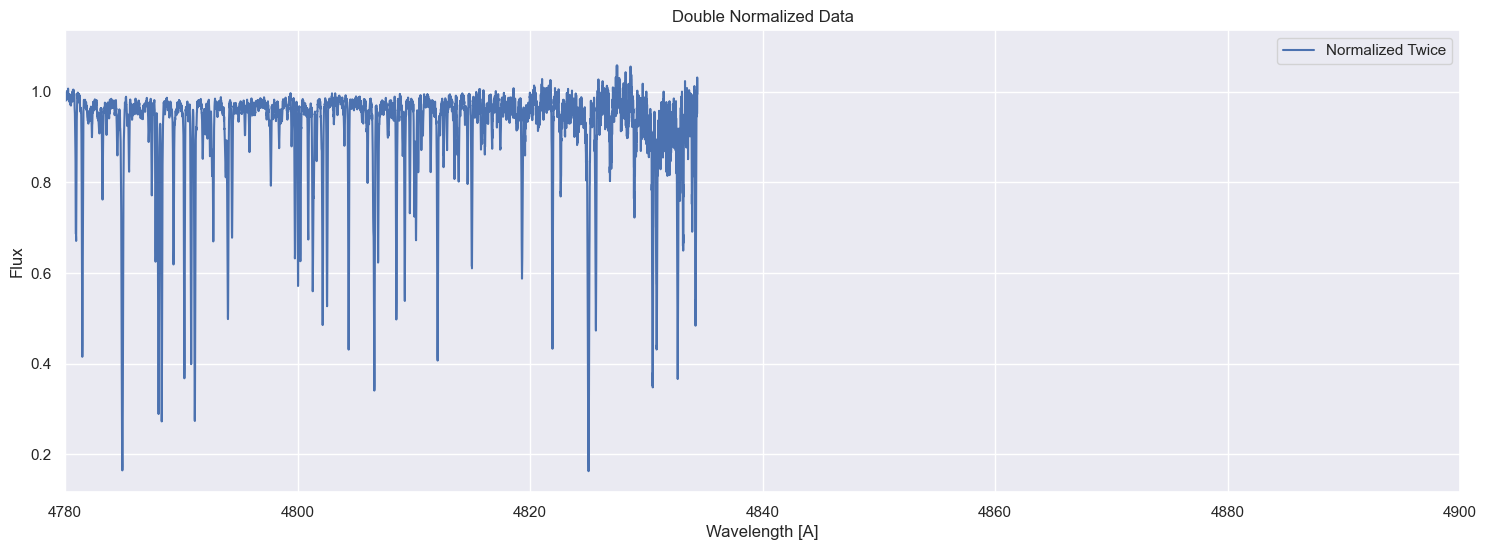

In [32]:
#this will plot the data from above again:

plt.plot(wl, normalized_flux, label = 'Normalized Twice')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data')


#zooming in on NA D lines:
plt.xlim(4780,4900)


plt.show()

_Hm it seems like this plot doesnt even have the necessary wavelengths for this kind of emission. . . gonna need to figure that out_